# EcotoxSystems.jl demo

In [4]:
using DrWatson 
using Pkg; Pkg.activate("./../test")

  Activating project at `c:\Users\shansul\Documents\Julia\EcotoxSystems.jl\test`


In [5]:
using EcotoxSystems

In [8]:
using Distributions, DataFrames

In [13]:
using StatsPlots
using Distributions 
using DataFrames

## Running the default model

In [14]:
p = deepcopy(EcotoxSystems.defaultparams)
p.glb.t_max = 21.
sim = EcotoxSystems.ODE_simulator(p)
first(sim, 5)

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase C:\Users\shansul\.julia\packages\SciMLBase\tWwhl\src\performance_warnings.jl:33


Row,t,X,C_W_1,N,embryo,juvenile,adult,X_emb,S,H,R,f_X,I_emb,I_p,I,A,M,J,D_z_1_1,D_z_1_2,D_z_1_3,D_z_1_4,D_h_1,y_T,y_z_1_1,y_z_1_2,y_z_1_3,y_z_1_4,y_j_1_1,y_j_1_2,y_j_1_3,y_j_1_4,h_z,S_z,S_max_hist,id,cohort,age,cause_of_death,time_since_last_repro,cum_repro
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,1200.0,0.0,1.0,1.0,0.0,0.0,19.42,0.01942,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.01942,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,2400.0,0.0,1.0,1.0,0.0,0.0,4.2591,1.88236,1.98108,0.0,0.979589,0.0,0.0,15.1609,5.0031,0.367993,0.325347,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.01942,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,3541.52,0.0,1.0,0.0,1.0,0.0,4.21076e-15,8.55729,8.99398,0.0,0.985179,0.0,0.0,77.8956,25.7055,3.18294,2.85627,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.01942,1.0,0.0,0.0,0.0,0.0,0.0
4,3.0,4610.1,0.0,1.0,0.0,1.0,0.0,4.21076e-15,20.5821,21.5173,0.0,0.989208,0.0,0.0,209.318,69.0749,11.5281,10.3262,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.01942,1.0,0.0,0.0,0.0,0.0,0.0
5,4.0,5598.97,0.0,1.0,0.0,1.0,0.0,4.21076e-15,37.1544,38.6421,0.0,0.991005,0.0,0.0,420.451,138.749,28.367,25.3211,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.01942,1.0,0.0,0.0,0.0,0.0,0.0


In [15]:
sim = DataFrame()
let Tvec = [17.5, 20., 22.5] # simulate three ambient temperatures
    for T in Tvec
        p.glb.T = 273.15 + T # succesively lower the food input rate
        sim_i = EcotoxSystems.ODE_simulator(p) # generate the predidction
        sim_i[!,:T] .= T
        append!(sim, sim_i) 
    end
end

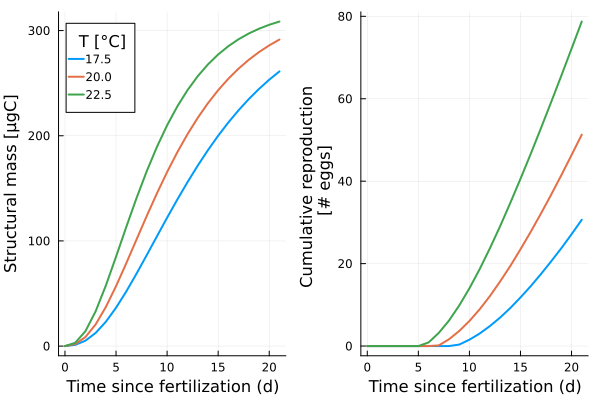

In [16]:
using StatsPlots

fig1 = @df sim plot(
    plot(:t, :S, group = :T, legendtitle = "T [°C]"), 
    plot(:t, trunc.(:R) ./ p.spc.X_emb_int, group = :T, leg = false), 
    lw = 2, 
    xlabel = "Time since fertilization (d)", 
    ylabel = ["Structural mass [μgC]" "Cumulative reproduction \n [# eggs]"]
)

savefig(plot(fig1, dpi = 400), "fig1.png")

fig1

## Individual-based simulation

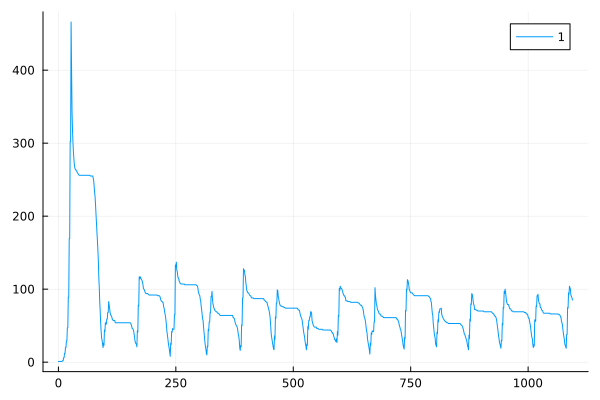

In [30]:
p = deepcopy(EcotoxSystems.defaultparams)

p.glb.t_max = 365*3 # adjust simulated timespan 
p.glb.dX_in = 10_000 # provide more food 
p.glb.V_patch = 0.5

p.spc.Z = Truncated(Normal(1, 0.1), 0, Inf) # induce individual variability 
p.spc.a_max = Truncated(Normal(60, 6), 0, Inf) # assign maxmimum life-span with variability
p.spc.S_rel_crit = 0.75
p.spc.h_S = -log(0.75)
p.spc.K_X = 2000.

sim_i = @replicates EcotoxSystems.IBM_simulator(p) 1

@df sim_i.glb plot(:t, :N, group = :replicate)

In [39]:
using Distributions, ProgressMeter

p = deepcopy(EcotoxSystems.defaultparams)
p.glb.t_max = 365. # simulated timespan [d]
p.glb.V_patch = 0.5 # simulated volume [L]
p.spc.Z = Truncated(Normal(1, 0.1), 0, Inf) # induce individual variability 
p.glb.dX_in = 10_000 # provide more food 
p.spc.S_rel_crit = 0.5
p.spc.h_S = -log(0.5)

Tvec = [17.5, 20., 22.5] # simulate these ambient temperatures
sims = [] # initialize output data frame
for (i,T) in enumerate(Tvec) # iterate over temepratures
    p.glb.T = 273.15 + T # update temperature in Kelvin
    sim_i = @replicates EcotoxSystems.IBM_simulator(p, showinfo = Inf) 10 # run replicated simulations
    sim_i.glb[!,:T] .= p.glb.T # add column indicating temperature to global output dataframe
    sim_i.spc[!,:T] .= p.glb.T # add column indicating temperature to species-level output dataframe
    push!(sims, sim_i) 
end
sims = EcotoxSystems.combine_outputs(Vector{typeof(sims[1])}(sims));

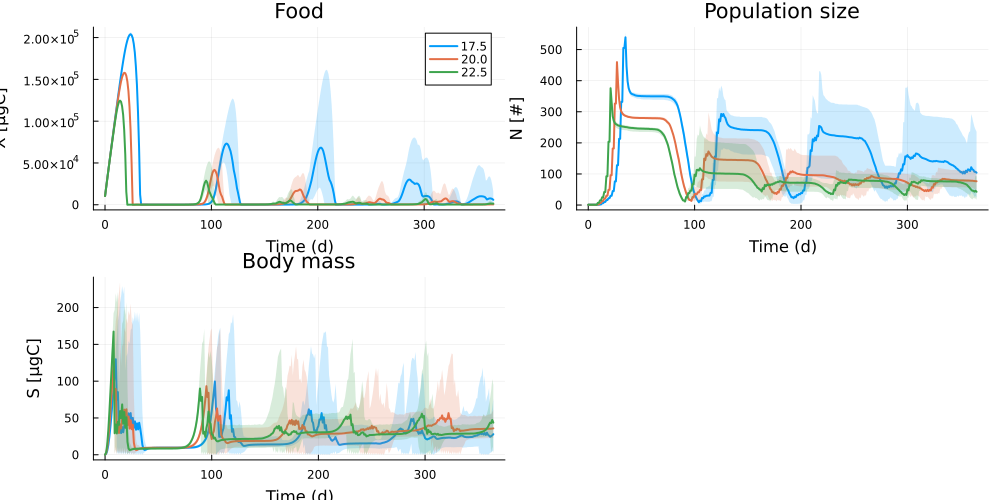

In [40]:
plot(
    (@df sims.glb groupedlineplot(:t, :X, :T, xlabel = "Time (d)", ylabel = "X [μgC]", label = hcat(unique(:T .- 273.15)...))), 
    (@df sims.glb groupedlineplot(:t, :N, :T, xlabel = "Time (d)", ylabel = "N [#]", leg = false)), 
    (@df sims.spc groupedlineplot(:t, :S, :T, xlabel = "Time (d)", ylabel = "S [μgC]", leg = false)),
    size = (1000,500), title = ["Food" "Population size" "Body mass"], lw = 2, fillalpha = .2
)